#### This notebook runs through an example of using a KDTree to optimize otherwise expensive code 
- in this case we are using Scipy's spatial library to find every galaxy's smallest 3D distance to its closest filament 
- this code depends on functions defined in the filament metrics catalog so they must be called (and the path must be updated for everyone's local computer)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits import mplot3d
from matplotlib import cm
import mpl_toolkits.mplot3d.art3d as art3d

import os
import pandas as pd
from scipy import spatial #this is what we use to implement KDTree

matplotlib.rcParams['font.family'] = [ 'serif']
matplotlib.rcParams['agg.path.chunksize'] = 10000

In [16]:
import sys  

sys.path.insert(0, '/Users/Daniel/Documents/Research Projects/Cosmic Filaments/example_filaments') #change path to your local here (last part should be the same if cloned from GitHub)
import read_fils as rf #need this to import Janvi's package to work with DisPerSE files

sys.path.insert(0, '/Users/Daniel/Documents/Research Projects/Cosmic Filaments/Filament_Metrics' ) #change here as well 
import fil_metrics.metric_functions as fm #need this to use fil metrics functions for manipulating dictionary of filaments 

skeleton_file_dm = '/Users/Daniel/Documents/Research Projects/Cosmic Filaments/GAMA_filaments/GAMA_tess.NDnet_s5.up.NDskl.S002.BRK.ASMB.rmO.rmB.a.NDskl' #change here as well 
filaments_dm = rf.ReadFilament(skeleton_file_dm) 
filament_dm_dict = filaments_dm.filament_dict
print(filament_dm_dict) 

header1, ANDSKEL

ndims, 3

Comments, #No comments (RB) (RB) (RB) (RB) (RB)

Bounding box, BBOX [-1436.7,-987.426,-78.1993] [1440.62,2098.18,156.865]

ncrit, 3588
nfils, 3679
Reading data fields:
CP field: persistence_ratio

CP field: persistence_nsigmas

CP field: persistence

CP field: robustness_ratio

CP field: robustness

CP field: persistence_pair

CP field: parent_index

CP field: parent_log_index

CP field: log_field_value

CP field: field_value

CP field: cell

Filament field: field_value

Filament field: orientation

Filament field: cell

Filament field: log_field_value

Filament field: type

Filament field: robustness

Filament field: robustness_ratio

Reading filaments took 0.08 secs.
{'ncrit': 3588, 'critical_points': [{'cp_idx': 2.0, 'px': -218.108, 'py': -153.104, 'pz': 5.52731, 'pair_ID': 494.0, 'boundary': 0.0, 'nfil': 2, 'destID,filID': [[1, 0], [2, 1]], 'Field Vals': [7.656654, 5.473076, 0.005868105, 7.994838, 0.006166227, 494.0, -1.0, -1.0, -2.170719, 0.006749645, 8

In [17]:
filament_dm_dict.keys()

dict_keys(['ncrit', 'critical_points', 'nfils', 'filaments', 'nb_CP_fields', 'CP_fields', 'nb_fil_fields', 'fil_fields'])

In [18]:
#separate 'filaments' and 'critical_points' dictionaries (each is now a list of dictionaries)
fils = filament_dm_dict['filaments'] 
crit_points = filament_dm_dict['critical_points'] 
#number of filaments
nfils = filament_dm_dict['nfils'] ; ncrit = filament_dm_dict['ncrit']
print("# of filaments: ",nfils,"\n","# of critical points :",ncrit)

# of filaments:  3679 
 # of critical points : 3588


In [19]:
# CREATE DATAFRAME OF FILAMENT POINTS WHILE KEEPING FILAMENT ID -- INCLUDING SEGMENTS
df = pd.DataFrame()
for i in range(filament_dm_dict['nfils']):
    p = np.array(filament_dm_dict['filaments'][i]['px,py,pz'])
    p = np.hstack([p[:-1],p[1:]]) #removing final element of first parts and first element of second (to address 'picket fence' problem)
    p = pd.DataFrame(p,columns = ['px', 'py', 'pz','px2','py2','pz2']) #adding the second pair of points (the 'end' part of the extremity)
    p['Filament ID'] = i
    df = pd.concat([df, p])
df 

,px,py,pz,px2,py2,pz2,Filament ID
0,-218.108,-153.104,5.52731,-214.830,-150.358,8.16807,0
1,-214.830,-150.358,8.16807,-212.155,-147.191,9.33830,0
2,-212.155,-147.191,9.33830,-210.049,-144.316,9.33611,0
3,-210.049,-144.316,9.33611,-208.257,-142.392,9.13846,0
4,-208.257,-142.392,9.13846,-206.576,-141.051,9.01675,0
...,...,...,...,...,...,...,...
2,-824.080,-770.452,-5.33363,-822.003,-772.237,-6.29777,3677
0,-823.801,-728.619,-29.48720,-823.578,-728.600,-32.58120,3678
1,-823.578,-728.600,-32.58120,-822.746,-728.210,-34.12370,3678
2,-822.746,-728.210,-34.12370,-821.686,-727.488,-34.64460,3678


In [20]:
filarray = np.array(df) #personally prefer to work with arrays
filarray[0] #array of filaments where each element contains the two pair of points that constitute a segment of the filament and the filament ID

array([-218.108  , -153.104  ,    5.52731, -214.83   , -150.358  ,
          8.16807,    0.     ])

In [38]:
#import galaxies 
dfgalaxies = pd.read_csv('/Users/Daniel/Documents/Research Projects/Cosmic Filaments/Gama_Galaxies/Gama_Catalog_Euclidean_copy.txt', delimiter=' ')
dfgalaxies

,px,py,pz,logmstar
0,-216.625210,22.745292,2.740837,9.076030
1,-1224.886159,128.248150,15.175059,10.979200
2,-895.469883,92.526596,10.353321,10.791600
3,-1209.953065,124.842693,17.067738,11.119700
4,-323.199357,33.861492,3.776433,9.012390
...,...,...,...,...
113153,-871.610163,-719.567317,23.754061,10.410600
113154,-687.527336,-580.637147,16.334981,9.689020
113155,-0.215265,-0.154865,0.007690,0.464692
113156,-1.102929,-1.020451,0.040281,1.253310


In [40]:
galaxies = np.array(dfgalaxies.iloc[:,:-1]) #removes logmstar and makes into array 
galaxies

array([[-2.16625210e+02,  2.27452918e+01,  2.74083730e+00],
       [-1.22488616e+03,  1.28248150e+02,  1.51750591e+01],
       [-8.95469883e+02,  9.25265956e+01,  1.03533213e+01],
       ...,
       [-2.15265246e-01, -1.54865181e-01,  7.69026908e-03],
       [-1.10292917e+00, -1.02045078e+00,  4.02806750e-02],
       [-5.08890334e+02, -6.81790904e+00, -1.11192676e+00]])

#### KDTree implementation (outside of loop)

In [41]:
#index filament segment pairs array here 
segment1 = filarray[:,:-4]
segment1 #corresponds to the first three columns of the array (which are the first/beginning extremities of each filament segment)

array([[-218.108  , -153.104  ,    5.52731],
       [-214.83   , -150.358  ,    8.16807],
       [-212.155  , -147.191  ,    9.3383 ],
       ...,
       [-823.578  , -728.6    ,  -32.5812 ],
       [-822.746  , -728.21   ,  -34.1237 ],
       [-821.686  , -727.488  ,  -34.6446 ]])

In [42]:
#actual KDTree implementation is here 
knn = 10 #decide here how many nearest neighbors you want (will decide how many indeces are returned for each galaxy)

distance, index = spatial.KDTree(segment1).query(galaxies, k=knn) 
index #index of single closest filament_array point for each galaxy

array([[ 8427,  8423,  9432, ...,  8421,  8429,  8420],
       [23664, 23663, 23665, ..., 23627, 23629, 23668],
       [11835, 11834, 11838, ..., 11837, 11833, 12362],
       ...,
       [ 7908,  7907,  8307, ...,  7949,  7946,  7909],
       [ 1178,  1179,  1177, ...,  1183,  1194,  1175],
       [ 5467,  5468,  5469, ...,  5470,  5457,  5404]])

Look how fast that was - 0.2 seconds to find 10 nearest neighbors for 100,000 galaxies against 3,000 points 

In [43]:
index[0] #returns array of 10 closest filament segment extremity points for FIRST galaxy

array([8427, 8423, 9432, 8428, 8422, 9431, 8438, 8421, 8429, 8420])

In [45]:
distance[0] #returns array of 10 closest fil segment extremity distances for FIRST galaxy

array([ 9.05891106, 10.43826933, 11.16331334, 11.25175579, 12.41400632,
       12.79584699, 13.46362867, 13.49741058, 13.57628566, 13.7772739 ])

In [51]:
print(len(index[0]),"\n\n", len(index))

10 

 113158


### Now use ***INDEX*** array from KDTree to run filament - galaxy distance calculations 

In [52]:
#galfildist is already defined in metric_functions package -- but showing it here to see how the *INDEX* array from KDTree plays a role in optimization 
def galfildist(galaxies, filament_points, KDTindex): #KDTindex is where you insert array
    '''Finds closest distance between an array of galaxies and 
        an array of filament points. The filament_points array must be 
        segmented so that the first element corresponds to the first pair of points
        (which correspond to the first two points of a filament segment's extremity).
        This code is optimized and intended to be used AFTER implementing a KDTree.
        KDTindex must correspond to the index array that comes out of using KDTree.'''
    shortest_distances = np.zeros(len(galaxies))
    for h in range(len(galaxies)):
        distances = np.zeros(len(KDTindex[0])) #distances should be same size as number of knn checked in KDTree 
        workingarray = filament_points[KDTindex[h]]
        for i in range(len(workingarray)): #nested loop but only for the number of knn there are 
            #A corresponds to first extremity point of segment, B to the second extremity point
            A = workingarray[i,:-4] ; B = workingarray[i,3:-1] ; AB = B - A ; AG = galaxies[h] - A
            u = AB / np.linalg.norm(AB) #creation of unit vector 
            #Statement checks 
            if np.dot(AG, u) < 0:
                distances[i] = np.linalg.norm(galaxies[h] - A)
            elif np.dot(AG, u) > np.linalg.norm(AB):
                distances[i] = np.linalg.norm(galaxies[h] - B)
            elif np.dot(AG, u) < np.linalg.norm(AB):
                distances[i] = np.linalg.norm((np.cross((A-B), (A-galaxies[h])))) / (np.linalg.norm(galaxies[h]-B))
        shortest_distances[h] = np.min(distances)
    return shortest_distances

In [54]:
gf_distances = galfildist(galaxies, filarray, index)

Voila! Look at that - 8 seconds to run! Previously these calculations took 2+ hours to run

In [55]:
gf_distances.shape #shape should match number of galaxies

(113158,)

Text(0.5, 0, 'Distance (Mpc)')

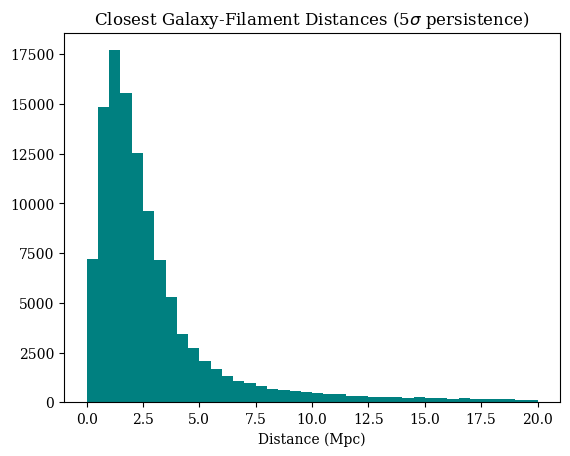

In [60]:
#plot the distances
plt.hist(gf_distances[gf_distances<20], bins = 40, color = 'teal') #using only gf_distances below 20 - there are some outliers due to selection effect most likely
plt.title('Closest Galaxy-Filament Distances (5$\sigma$ persistence)')
plt.xlabel('Distance (Mpc)')